In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import torch
import torchvision

import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

torch.__version__, torchvision.__version__

('0.4.1', '0.2.1')

# Read xarray data

In [2]:
ds = xr.open_dataset('./graphene_processed.nc').astype(np.float32)
ds

<xarray.Dataset>
Dimensions:       ()
Data variables:
    coarse_image  (sample, y_c, x_c) float32 1.0 0.0 0.0 1.0 1.0 0.0 1.0 0.0 ...
    fine_image    (sample, y, x) float32 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    strain        (sample) float32 0.27717704 0.30521148 0.24878655 ...
    stress        (sample) float32 46.20475 65.82303 56.71409 54.158566 ...

In [3]:
X = ds['coarse_image'].values  # the coarse 3x5 image seems enough
# X = ds['fine_image'].values  # the same model works worse on higher resolution image

y = ds['strain'].values

X = X[..., np.newaxis]  # add channel dimension
y = y[:, np.newaxis]  # pytorch wants ending 1 dimension

# pytorch conv2d wants channel-first, unlike Keras
X = X.transpose([0, 3, 1, 2])  # (sample, x, y, channel) -> (sample, channel, x, y)

X.shape, y.shape

((29791, 1, 3, 5), (29791, 1))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((23832, 1, 3, 5), (5959, 1, 3, 5))

In [5]:
X_train.shape

(23832, 1, 3, 5)

# Build pytorch dataset

In [6]:
# https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader

trainset = torch.utils.data.TensorDataset(
    torch.from_numpy(X_train), torch.from_numpy(y_train)
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=4, shuffle=True, num_workers=2
)

In [7]:
dataiter = iter(trainloader)
inputs, labels = dataiter.next()
inputs.shape, labels.shape  # batch, channel, x, y

(torch.Size([4, 1, 3, 5]), torch.Size([4, 1]))

In [8]:
x = nn.Conv2d(1, 64, 3, padding=1)(inputs)
x = nn.Conv2d(64, 64, 3, padding=1)(x)
#x = x.view(-1, 16 * 5 * 5)

x.shape

torch.Size([4, 64, 3, 5])

In [9]:
nn.Conv2d(1, 64, 3, padding=1)

Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [10]:
class Net(nn.Module):
    def __init__(self,):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 3 * 5, 1)  # filter * x * y

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 64 * 3 * 5)
        x = self.fc1(x)
        return x

net = Net()

In [11]:
%%time

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters())

for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:
            print('[%d, %5d] loss: %.4f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

[1,  1000] loss: 0.0226
[1,  2000] loss: 0.0106
[1,  3000] loss: 0.0080
[1,  4000] loss: 0.0059
[1,  5000] loss: 0.0066
[2,  1000] loss: 0.0056
[2,  2000] loss: 0.0047
[2,  3000] loss: 0.0047
[2,  4000] loss: 0.0043
[2,  5000] loss: 0.0043
[3,  1000] loss: 0.0036
[3,  2000] loss: 0.0043
[3,  3000] loss: 0.0039
[3,  4000] loss: 0.0040
[3,  5000] loss: 0.0040
[4,  1000] loss: 0.0036
[4,  2000] loss: 0.0036
[4,  3000] loss: 0.0033
[4,  4000] loss: 0.0034
[4,  5000] loss: 0.0032
Finished Training
CPU times: user 3min 6s, sys: 6.15 s, total: 3min 12s
Wall time: 1min 8s


In [12]:
PATH = './graphene_net.pth'
torch.save(net.state_dict(), PATH)

In [13]:
ls -lh graphene_net.pth

-rw-r--r--  1 zhuangjw  staff   152K Oct  5 13:22 graphene_net.pth


## Evaluate

In [14]:
with torch.no_grad():
    y_test_pred = net(torch.from_numpy(X_test)).numpy()
    
y_test_pred.shape

(5959, 1)

In [15]:
y_test.shape

(5959, 1)

In [16]:
r2_score(y_test, y_test_pred)

0.9014841368178129

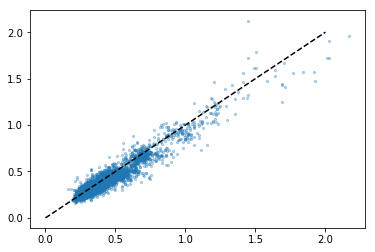

In [17]:
plt.scatter(y_test, y_test_pred, alpha=0.3, s=5)
plt.plot([0, 2], [0, 2], '--', c='k')